In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
#from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Modelos
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB


In [61]:
dataset = pd.read_csv('assets/train.csv')

In [62]:
datatest = pd.read_csv('assets/test.csv')

In [63]:
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Análise Exploratória

In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Podemos perceber que o datas set possui 7 features categóricas e 6 numéricas. 
E vários dados faltantes em quase todas as features, pois temos 8693 dados não nulos na coluna "Transported".

In [65]:
print('DADOS FALTANTES DO TREINO:')
print(dataset.isna().sum())
print('')
print('DADOS FALTANTES DO TESTE:')
print(datatest.isna().sum())

DADOS FALTANTES DO TREINO:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

DADOS FALTANTES DO TESTE:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Primeiramente vamos fazer a análise exploratória dos dados, isto porque teremos uma noção melhor dos dados como um todo antes de lidar com estes dados faltantes.

## Análise dos dados numéricos.

Text(0.5, 0, 'Idade em anos')

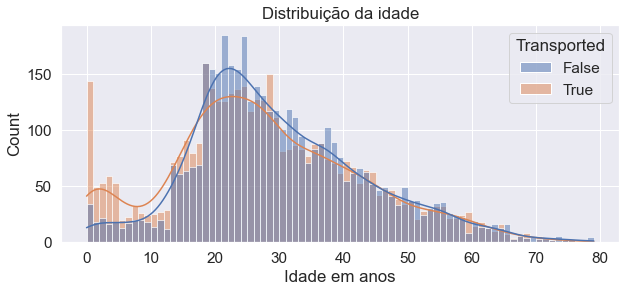

In [66]:
plt.figure(figsize=(10,4))
sns.histplot(data=dataset, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Distribuição da idade')
plt.xlabel('Idade em anos')

Podemos perceber que pessoas mais jovens tiveram mais chances de serem tranpostadas do que as mais velhas. 
Pessoas entre 20 e 30 anos tiveram menos chances de serem tranpostadas. 

Criarei uma nova coluna separando as idades por grupos. 

In [67]:
dataset['Age_group']=np.nan
dataset.loc[dataset['Age']<=12,'Age_group']= 0
dataset.loc[(dataset['Age']>12) & (dataset['Age']<18),'Age_group']=1
dataset.loc[(dataset['Age']>=18) & (dataset['Age']<=25),'Age_group']=2
dataset.loc[(dataset['Age']>25) & (dataset['Age']<=30),'Age_group']=3
dataset.loc[(dataset['Age']>30) & (dataset['Age']<=50),'Age_group']=4
dataset.loc[dataset['Age']>50,'Age_group']=5


datatest['Age_group']=np.nan
datatest.loc[datatest['Age']<=12,'Age_group']=0
datatest.loc[(datatest['Age']>12) & (datatest['Age']<18),'Age_group']=1
datatest.loc[(datatest['Age']>=18) & (datatest['Age']<=25),'Age_group']=2
datatest.loc[(datatest['Age']>25) & (datatest['Age']<=30),'Age_group']=3
datatest.loc[(datatest['Age']>30) & (datatest['Age']<=50),'Age_group']=4
datatest.loc[datatest['Age']>50,'Age_group']=5

Text(0.5, 0, 'Grupo das idades')

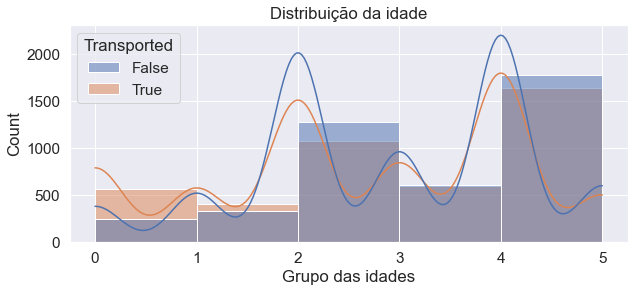

In [68]:
plt.figure(figsize=(10,4))

sns.histplot(data=dataset, x='Age_group', hue='Transported', binwidth=1, kde=True)
plt.title('Distribuição da idade')
plt.xlabel('Grupo das idades')

Explorando as Features de gastos.

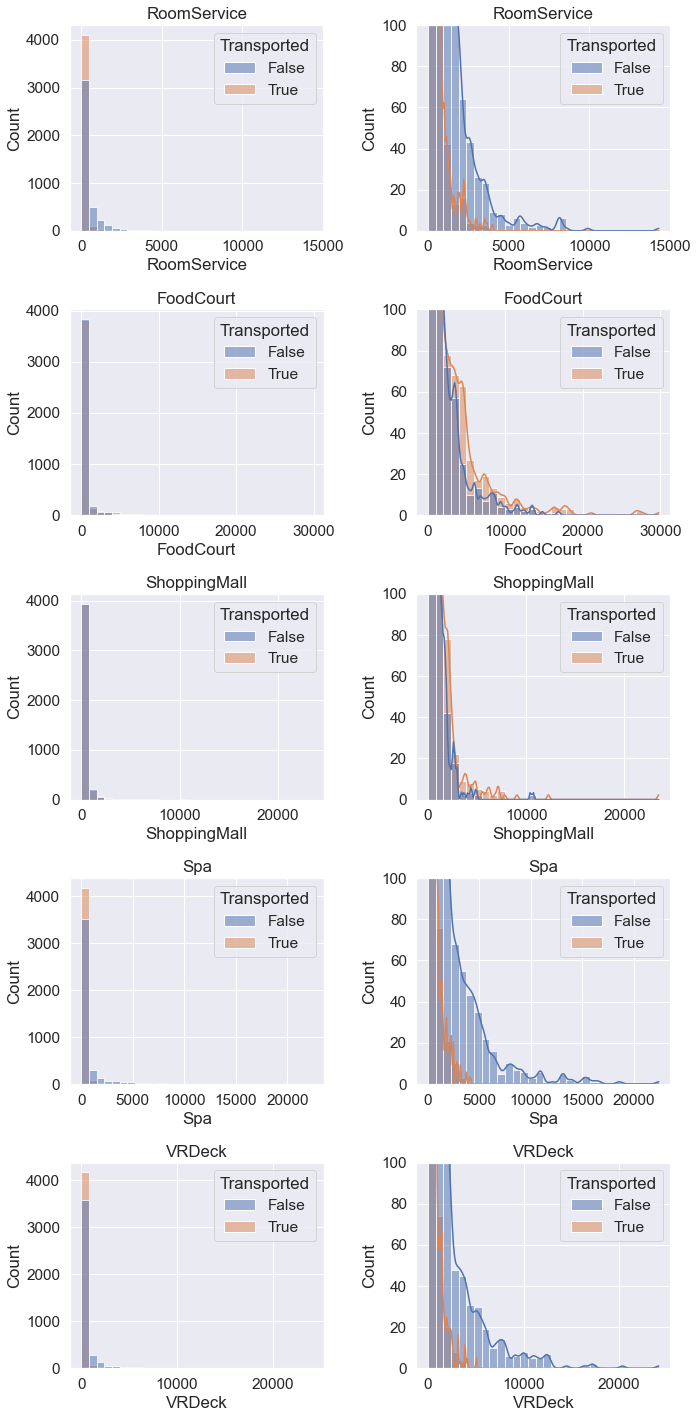

In [69]:
# Features de gastos
gastos_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(gastos_feats):
    # Plot normal
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=dataset, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Plot truncado
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=dataset, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

Podemos perceber algumas coisas:
- A maioria das pessoas não gastaram dinheiro. 
- As distribuições de RomService, Spa e VRDeck são diferentes das outras, pois nestes casos percebe-se que as pessoas que gastaram menos tiveram uma tendência maior de serem transpostadas.

Criarei duas novas features, uma com o total gasto por cada pessoa e uma binária se a pessoa gastou ou não.

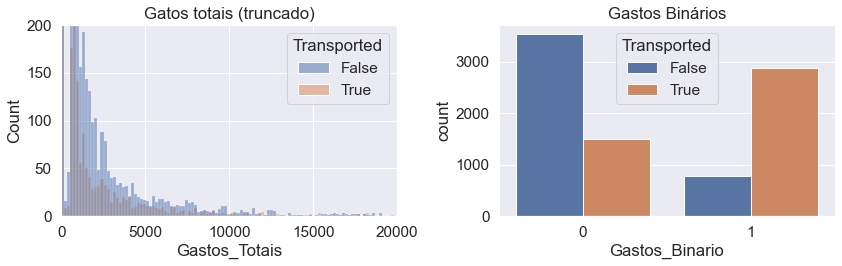

In [70]:
dataset['Gastos_Totais']=dataset[gastos_feats].sum(axis=1)
dataset['Gastos_Binario']=(dataset['Gastos_Totais']==0).astype(int)

# New features - test set
datatest['Gastos_Totais']=datatest[gastos_feats].sum(axis=1)
datatest['Gastos_Binario']=(datatest['Gastos_Totais']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=dataset, x='Gastos_Totais', hue='Transported', bins=200)
plt.title('Gatos totais (truncado)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=dataset, x='Gastos_Binario', hue='Transported')
plt.title('Gastos Binários')
fig.tight_layout()

## Análise dos dados Categóricos  

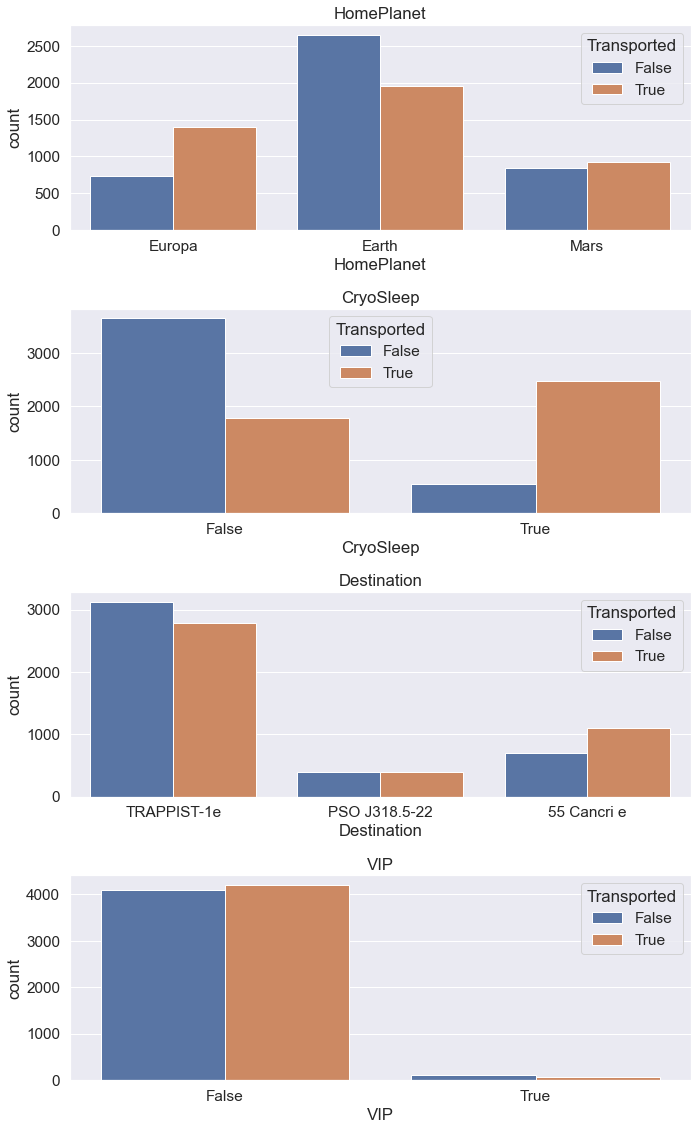

In [71]:
# Features Categoricas
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=dataset, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  
plt.show()

Em relaçao ao planeta de origem podemos ver que:
- Quem vem do planeta Europa tem mais chances de ser tranportado.
- Quem vem do planeta Terra tem menos chances de ser transportado.
- Quem vem de Marte tem chances equilibradas.

Em relação ao estado de Cryosleep:
- Quem estava em CryoSleep tiveram bem mais chances de serem transportados. 

Isto mostra que esssa feature deve ser muito importante no modelo.

Em relação ao destino da viagem as variavéis parecem ser equilibradas. 

Na feature VIP podemos perceber que a grande maioria é de false. Não irei usar essa features para não gerar overfiting.

In [72]:
dataset.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group,Gastos_Totais,Gastos_Binario
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,4.0,0.0,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,736.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,5.0,10383.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,4.0,5176.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1.0,1091.0,0
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,4.0,774.0,0
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True,3.0,1584.0,0
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,3.0,0.0,1
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True,4.0,1018.0,0
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True,1.0,0.0,1


Olhando para o dataset, podemos perceber que o PassegenderID é composto por um número que é o grupo do passageiro e o segundo número a indentificação do passageiro. 
Levando isto em consideração vamos separar estes números para melhor agrupamento dos dados.

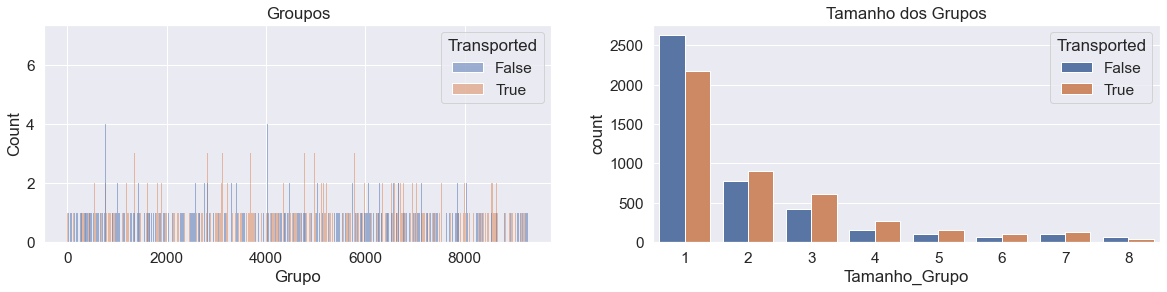

In [73]:

dataset['Grupo'] = dataset['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
datatest['Grupo'] = datatest['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)


dataset['Tamanho_Grupo']=dataset['Grupo'].map(lambda x: pd.concat([dataset['Grupo'], datatest['Grupo']]).value_counts()[x])
datatest['Tamanho_Grupo']=datatest['Grupo'].map(lambda x: pd.concat([dataset['Grupo'], datatest['Grupo']]).value_counts()[x])


plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=dataset, x='Grupo', hue='Transported', binwidth=1)
plt.title('Groupos')

plt.subplot(1,2,2)
sns.countplot(data=dataset, x='Tamanho_Grupo', hue='Transported')
plt.title('Tamanho dos Grupos')
fig.tight_layout()

Trabalhar com a feature grupo não parece ser uma boa ideia, pois sua cardinalidade é bem grande (maior que 6000) e demorou um pouco pra rodar o seu gráfico, já com a Tamanho_Grupo parece ser interessante, até mesmo por separar quem estava viajando sozinho.

O número da cabine de cada passageiro é composto por três itens, o deck, o número e o lado. Irei separar estes três dados. 

In [74]:
#Deixando os dados faltantes como outliers, no final eu volto para análise futura
dataset['Cabin'].fillna('Z/9999/Z', inplace=True)
datatest['Cabin'].fillna('Z/9999/Z', inplace=True)


dataset['Deck_Cabine'] = dataset['Cabin'].apply(lambda x: x.split('/')[0])
dataset['Numero_Cabine'] = dataset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
dataset['Lado_Cabine'] = dataset['Cabin'].apply(lambda x: x.split('/')[2])


datatest['Deck_Cabine'] = datatest['Cabin'].apply(lambda x: x.split('/')[0])
datatest['Numero_Cabine'] = datatest['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
datatest['Lado_Cabine'] = datatest['Cabin'].apply(lambda x: x.split('/')[2])

#Voltando com os dados faltantes
dataset.loc[dataset['Deck_Cabine']=='Z', 'Deck_Cabine']=np.nan
dataset.loc[dataset['Numero_Cabine']==9999, 'Numero_Cabine']=np.nan
dataset.loc[dataset['Lado_Cabine']=='Z', 'Lado_Cabine']=np.nan
datatest.loc[datatest['Deck_Cabine']=='Z', 'Deck_Cabine']=np.nan
datatest.loc[datatest['Numero_Cabine']==9999, 'Numero_Cabine']=np.nan
datatest.loc[datatest['Lado_Cabine']=='Z', 'Lado_Cabine']=np.nan

#Retirando a Feature Cabine, pois não preciso dela mais
dataset.drop('Cabin', axis=1, inplace=True)
datatest.drop('Cabin', axis=1, inplace=True)

Agora iremos fazer uma análise vizual destes dados separados.


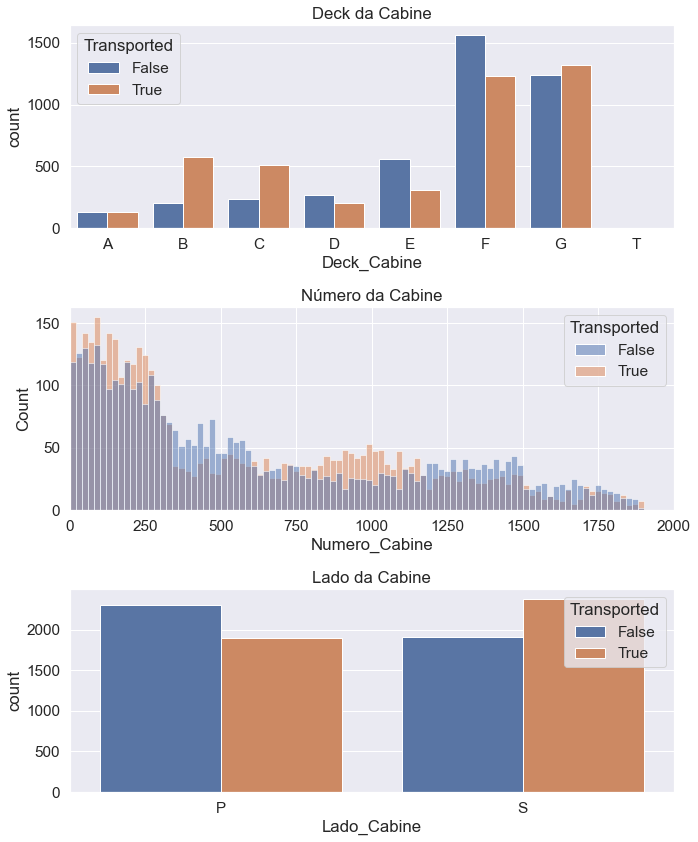

In [75]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=dataset, x='Deck_Cabine', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Deck da Cabine')

plt.subplot(3,1,2)
sns.histplot(data=dataset, x='Numero_Cabine', hue='Transported',binwidth=20)
plt.title('Número da Cabine')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=dataset, x='Lado_Cabine', hue='Transported')
plt.title('Lado da Cabine')
fig.tight_layout()


Aqui podemos perceber duas coisas:
- O Deck T parece ser um outlier(poucos casos)
- O Número da Cabine parece ter um padrão de em média cada 300 números, então vou agrupá-los.

In [76]:

dataset['Regiao_cabine_1']=(dataset['Numero_Cabine']<300).astype(int)   # one-hot encoding
dataset['Regiao_cabine_2']=((dataset['Numero_Cabine']>=300) & (dataset['Numero_Cabine']<600)).astype(int)
dataset['Regiao_cabine_3']=((dataset['Numero_Cabine']>=600) & (dataset['Numero_Cabine']<900)).astype(int)
dataset['Regiao_cabine_4']=((dataset['Numero_Cabine']>=900) & (dataset['Numero_Cabine']<1200)).astype(int)
dataset['Regiao_cabine_5']=((dataset['Numero_Cabine']>=1200) & (dataset['Numero_Cabine']<1500)).astype(int)
dataset['Regiao_cabine_6']=((dataset['Numero_Cabine']>=1500) & (dataset['Numero_Cabine']<1800)).astype(int)
dataset['Regiao_cabine_7']=(dataset['Numero_Cabine']>=1800).astype(int)


datatest['Regiao_cabine_1']=(datatest['Numero_Cabine']<300).astype(int)   # one-hot encoding
datatest['Regiao_cabine_2']=((datatest['Numero_Cabine']>=300) & (datatest['Numero_Cabine']<600)).astype(int)
datatest['Regiao_cabine_3']=((datatest['Numero_Cabine']>=600) & (datatest['Numero_Cabine']<900)).astype(int)
datatest['Regiao_cabine_4']=((datatest['Numero_Cabine']>=900) & (datatest['Numero_Cabine']<1200)).astype(int)
datatest['Regiao_cabine_5']=((datatest['Numero_Cabine']>=1200) & (datatest['Numero_Cabine']<1500)).astype(int)
datatest['Regiao_cabine_6']=((datatest['Numero_Cabine']>=1500) & (datatest['Numero_Cabine']<1800)).astype(int)
datatest['Regiao_cabine_7']=(datatest['Numero_Cabine']>=1800).astype(int)

Aqui separamos com o padrão do one-hot encoding, pensando que este é um bom método para manter a independência das Features região da cabine.

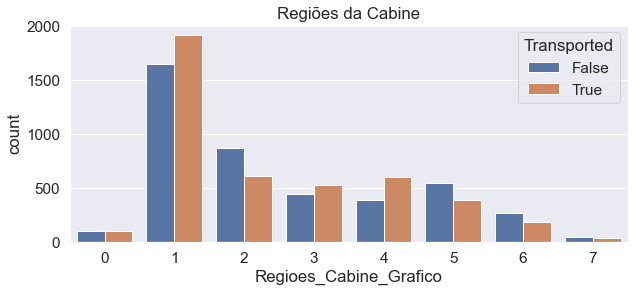

In [77]:
plt.figure(figsize=(10,4))
dataset['Regioes_Cabine_Grafico']=(dataset['Regiao_cabine_1']+2*dataset['Regiao_cabine_2']+3*dataset['Regiao_cabine_3']+4*dataset['Regiao_cabine_4']+5*dataset['Regiao_cabine_5']+6*dataset['Regiao_cabine_6']+7*dataset['Regiao_cabine_7']).astype(int)
sns.countplot(data=dataset, x='Regioes_Cabine_Grafico', hue='Transported')
plt.title('Regiões da Cabine')
dataset.drop('Regioes_Cabine_Grafico', axis=1, inplace=True)

## Lidando com os dados faltantes 

In [78]:
datatest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      4277 non-null   object 
 1   HomePlanet       4190 non-null   object 
 2   CryoSleep        4184 non-null   object 
 3   Destination      4185 non-null   object 
 4   Age              4186 non-null   float64
 5   VIP              4184 non-null   object 
 6   RoomService      4195 non-null   float64
 7   FoodCourt        4171 non-null   float64
 8   ShoppingMall     4179 non-null   float64
 9   Spa              4176 non-null   float64
 10  VRDeck           4197 non-null   float64
 11  Name             4183 non-null   object 
 12  Age_group        4186 non-null   float64
 13  Gastos_Totais    4277 non-null   float64
 14  Gastos_Binario   4277 non-null   int32  
 15  Grupo            4277 non-null   int32  
 16  Tamanho_Grupo    4277 non-null   int64  
 17  Deck_Cabine   

Podemos ver que o dataset de teste também tem dados faltantes. Para facilitar vou juntar o dado de treino e o dado de teste, sem a coluna dos transportados, para tratá-los ao mesmo tempo. 

In [79]:
data_transportados=dataset['Transported'].copy().astype(int)
dataset_sem_transportados=dataset.drop('Transported', axis=1).copy()

# Concatenate dataframes
datafaltantes=pd.concat([dataset_sem_transportados, datatest], axis=0).reset_index(drop=True)

Vamos preencher os dados faltantes da Feature HomePlanet

In [80]:
# HomePlanet por Grupo(hpg)
hpg=datafaltantes.groupby(['Grupo','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
hpg.head()

HomePlanet,Earth,Europa,Mars
Grupo,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Número de planetas únicos por grupo')

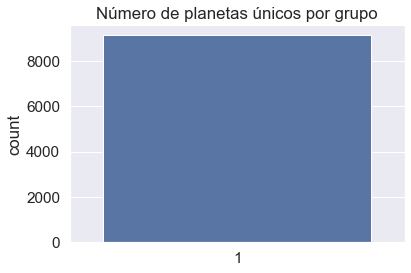

In [81]:
sns.countplot((hpg>0).sum(axis=1))
plt.title('Número de planetas únicos por grupo')

Podemos perceber que todos no mesmo grupo pertencem ao mesmo planeta de origem, então vamos preencher estes dados. 

In [82]:
hp_antes=datafaltantes['HomePlanet'].isna().sum()


hpg_index=datafaltantes[datafaltantes['HomePlanet'].isna()][(datafaltantes[datafaltantes['HomePlanet'].isna()]['Grupo']).isin(hpg.index)].index


datafaltantes.loc[hpg_index,'HomePlanet']=datafaltantes.iloc[hpg_index,:]['Grupo'].map(lambda x: hpg.idxmax(axis=1)[x])


print('Número de dados faltantes em HomePlanet antes:',hp_antes)
print('Número de dados faltantes em HomePlanet depois:',datafaltantes['HomePlanet'].isna().sum())

Número de dados faltantes em HomePlanet antes: 288
Número de dados faltantes em HomePlanet depois: 157


In [83]:
# HomePlanet por Deck
hpdk=datafaltantes.groupby(['Deck_Cabine','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

<AxesSubplot:xlabel='Deck_Cabine', ylabel='HomePlanet'>

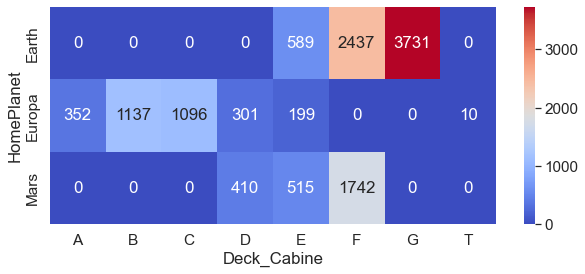

In [84]:
plt.figure(figsize=(10,4))
sns.heatmap(hpdk.T, annot=True, fmt='g', cmap='coolwarm')

Podemos perceber que:
- Passageiros dos grupos A, B, C e T vem do planeta Europa. 
- Passageiros do grupo G vem do planeta Terra. 
- Passageiros dos grupos D, E e F podem vim de planetas diferentes. 

Sendo assim, podemos preencher os dados dos grupos A, B, C, G e T.

In [86]:

hp_antes=datafaltantes['HomePlanet'].isna().sum()


datafaltantes.loc[(datafaltantes['HomePlanet'].isna()) & (datafaltantes['Deck_Cabine'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'


datafaltantes.loc[(datafaltantes['HomePlanet'].isna()) & (datafaltantes['Deck_Cabine']=='G'), 'HomePlanet']='Earth'


print('Número de dados faltantes em HomePlanet antes:',hp_antes)
print('Número de dados faltantes em HomePlanet depois:',datafaltantes['HomePlanet'].isna().sum())


Número de dados faltantes em HomePlanet antes: 157
Número de dados faltantes em HomePlanet depois: 94


Hipótese: Pessoas da mesma família devem vir de um mesmo planeta.


Então vou separar os passageiros pelo sobrenome.